In [1]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pymc3 as pm
import theano as tt

sns.set(font_scale=1.5)
%matplotlib inline

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
dst = pd.read_hdf('Dst_data.h5')
dst.head()

,Dst
1963-01-01 00:30:00,-6.0
1963-01-01 01:30:00,-5.0
1963-01-01 02:30:00,-5.0
1963-01-01 03:30:00,-3.0
1963-01-01 04:30:00,-3.0


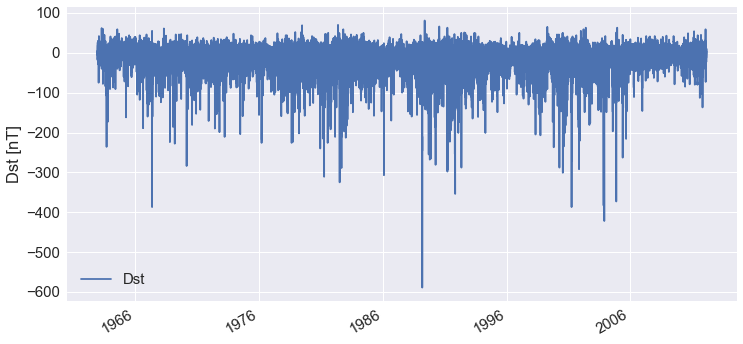

In [3]:
dst = pd.read_hdf('Dst_data.h5')
dst.plot(figsize=(12,6))
plt.ylabel('Dst [nT]');

In [7]:
def logp(value):
     return value - pm.math.exp(value)

with pm.Model() as model:
    scale = pm.Uniform('scale', 0, 100)
    loc = pm.Uniform('loc', -100, 100)
    y = (dst.loc['2000'].values - loc) / scale
    gumbel_l = pm.DensityDist('gumbel_l', logp, testval=0, observed=y)
    trace = pm.sample(1000, )

    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [loc_interval__, scale_interval__]
100%|██████████| 1500/1500 [00:06<00:00, 240.85it/s]


In [ ]:
pm.traceplot(trace, combined=True)
pm.summay(trace)